In [1]:
import pickle

from src.models import HLGC
from src.data import Newsgroups

In [2]:
#data = pickle.load(open('data/cifar100-resnet152.pickle', 'rb'))
data = pickle.load(open('data/20newsgroups.pickle', 'rb'))

In [3]:
hparams = {
    'n_features' : len(data['train']['features'][0]),
    'hidden_dim' : 128,
    'latent_dims' : [50, 50, 50],
    'batch_size' : 32,
    'lr' : 0.001,
    'dropout' : 0.5,
    'n_epochs' : 25,
    'early_stopping_epochs' : 5,
    'latent_loss_weight' : 1.0,
    'recon_loss_weight' : 1.0,
    'l1_lambda' : 0.001, 
    'val_split' : 0.1, 
    'display_interval' : 200
}

In [4]:
model = HLGC(
    len(data['flat_label_dict']), hparams['n_features'], hparams['latent_dims'], hidden_dim=hparams['hidden_dim'], 
    dropout_rate=hparams['dropout'], batch_size=hparams['batch_size'], lr=hparams['lr'], 
    n_epochs=hparams['n_epochs'], class_weights=data['class_weights'], recon_loss_weight=hparams['recon_loss_weight'], 
    latent_loss_weight=hparams['latent_loss_weight'], 
    l1_lambda=hparams['l1_lambda'], display_interval=hparams['display_interval'], 
    early_stopping_epochs=hparams['early_stopping_epochs'], label_dict=data['flat_label_dict']
)

No validation data provided, using 10.0% of train data
[0,     1] loss - (total : 13.448099, clf : 3.008560, support : 3.000631, recon : 3.596349, latent : 3.032797), acc - (clf : 0.031250, recon : 0.031250)
[0,   200] loss - (total : 6.661711, clf : 1.918022, support : 2.096019, recon : 0.527724, latent : 2.036080), acc - (clf : 0.875000, recon : 0.697917)
[ Eval ] loss - (total : 5.024698, clf : 1.259294, support : 1.659391, recon : 0.383302, latent : 1.608355), acc - (clf : 0.868375, support : 0.317138, recon : 0.769729)
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 48, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 68]
-----
alt.atheism : [4, 18, 95]
rec.sport.baseball : [4, 18, 0]
sci.med : [4, 48, 0]
soc.religion.christian : [4, 18, 0]
talk.politics.guns : [4, 48, 0]
talk.politics.mideast : [4, 18, 95]
talk.politics.misc : [4, 18, 0]
talk.religion.misc : [4, 18, 95]
-----
sci.space : [6, 34, 60]
-----
comp.graphics : [8, 41, 68]
comp.os.ms-windows.misc : [8, 41, 68]
comp.sy

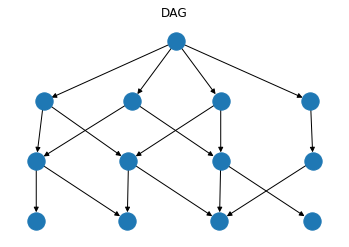

[1,   400] loss - (total : 4.475516, clf : 0.919416, support : 1.451920, recon : 0.516241, latent : 1.461101), acc - (clf : 0.906250, recon : 0.791667)
[1,   600] loss - (total : 3.917917, clf : 0.560054, support : 1.160306, recon : 0.776019, latent : 1.272512), acc - (clf : 0.937500, recon : 0.791667)
[ Eval ] loss - (total : 3.419329, clf : 0.602206, support : 1.195019, recon : 0.363145, latent : 1.109554), acc - (clf : 0.897527, support : 0.563604, recon : 0.837456)
rec.autos : [2, 48, 0]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 48, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
rec.sport.hockey : [4, 18, 95]
soc.religion.christian : [4, 18, 0]
talk.politics.guns : [4, 48, 52]
talk.politics.mideast : [4, 18, 0]
talk.politics.misc : [4, 48, 52]
talk.religion.misc : [4, 18, 0]
-----
rec.motorcycles : [6, 48, 60]
sci.space : [6, 34, 60]
-----
comp.graphics : [8, 41, 68]
comp.os.ms-windows.misc : [8, 41, 68]
comp.sys.ibm.pc.hardware : [8, 41

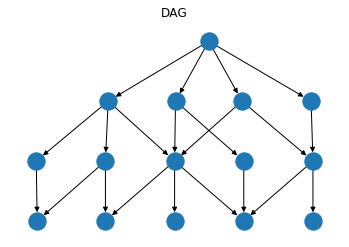

[2,   800] loss - (total : 1.993847, clf : 0.225647, support : 0.742408, recon : 0.150665, latent : 0.720120), acc - (clf : 0.968750, recon : 0.906250)
[ Eval ] loss - (total : 2.590448, clf : 0.420455, support : 0.905910, recon : 0.318414, latent : 0.790916), acc - (clf : 0.907244, support : 0.688163, recon : 0.876620)
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 41, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.med : [2, 48, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
rec.sport.hockey : [4, 18, 95]
soc.religion.christian : [4, 18, 0]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 68]
sci.space : [6, 34, 60]
-----
comp.os.ms-windows.misc : [8, 41, 60]
comp.sys.ibm.pc.hardware : [8, 41, 4]
comp.sys.mac.hardware : [8, 41, 4]
misc.forsale : [8, 41, 60]
sci.electronics : [8, 11, 60]


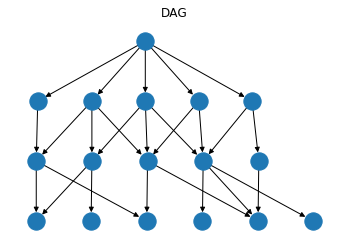

[3,  1000] loss - (total : 1.671103, clf : 0.156804, support : 0.542651, recon : 0.322174, latent : 0.491541), acc - (clf : 0.968750, recon : 0.875000)
[3,  1200] loss - (total : 1.029436, clf : 0.198809, support : 0.232729, recon : 0.220069, latent : 0.222736), acc - (clf : 1.000000, recon : 0.916667)
[ Eval ] loss - (total : 2.222499, clf : 0.348654, support : 0.777917, recon : 0.262342, latent : 0.681016), acc - (clf : 0.913428, support : 0.751767, recon : 0.896938)
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 52]
rec.sport.baseball : [4, 11, 95]
rec.sport.hockey : [4, 18, 95]
soc.religion.christian : [4, 18, 0]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 68]
sci.space : [6, 34, 60]
-----
comp.os.ms-windows.misc : [8, 41, 

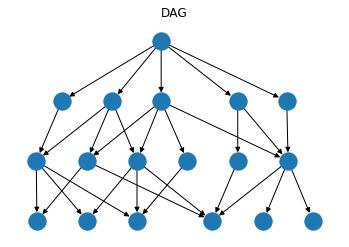

[4,  1400] loss - (total : 1.028480, clf : 0.135748, support : 0.295067, recon : 0.275286, latent : 0.170712), acc - (clf : 0.968750, recon : 0.937500)
[ Eval ] loss - (total : 1.994214, clf : 0.315872, support : 0.727669, recon : 0.192195, latent : 0.616528), acc - (clf : 0.915194, support : 0.813604, recon : 0.940518)
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 68]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 4]
sci.space : [6, 34, 60]
talk.politics.mideast : [6, 18, 0]
-----
rec.sport.hockey : [7, 18, 95]
-----
comp.os.ms-windows.misc : [8, 41, 68]
comp.sys.ibm.pc.hardware : [8, 41, 4]
comp.sys.mac.hardware : [8, 41, 4]
misc.forsale : [8, 41, 60]


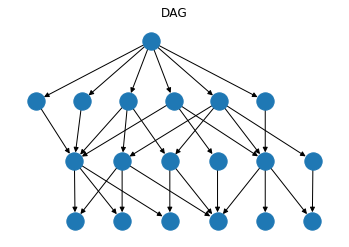

[5,  1600] loss - (total : 0.353253, clf : 0.020161, support : 0.092836, recon : 0.031635, latent : 0.066969), acc - (clf : 1.000000, recon : 0.947917)
[5,  1800] loss - (total : 0.626705, clf : 0.052669, support : 0.203567, recon : 0.063629, latent : 0.176961), acc - (clf : 0.968750, recon : 0.958333)
[ Eval ] loss - (total : 2.131258, clf : 0.304353, support : 0.715507, recon : 0.290590, latent : 0.697360), acc - (clf : 0.909894, support : 0.848057, recon : 0.932273)
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 95]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.sys.ibm.pc.hardware : [6, 41, 0]
comp.windows.x : [6, 41, 4]
sci.space : [6, 34, 60]
-----
rec.sport.hockey : [7, 

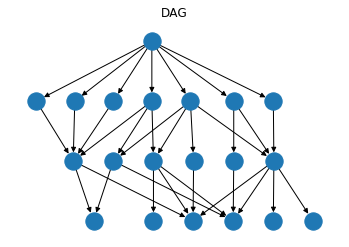

[6,  2000] loss - (total : 0.407766, clf : 0.032067, support : 0.101389, recon : 0.070630, latent : 0.080728), acc - (clf : 1.000000, recon : 0.947917)
[6,  2200] loss - (total : 0.594774, clf : 0.040721, support : 0.026912, recon : 0.158461, latent : 0.251512), acc - (clf : 0.968750, recon : 0.947917)
[ Eval ] loss - (total : 1.921338, clf : 0.302842, support : 0.709520, recon : 0.214525, latent : 0.578991), acc - (clf : 0.914311, support : 0.861307, recon : 0.941402)
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 4]
sci.electronics : [6, 41, 60]
sci.space : [6, 34, 60]
-----
rec.sport.hockey : [7, 18, 95]
-----
comp.os.ms-windows.misc 

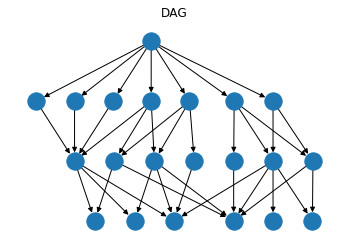

[7,  2400] loss - (total : 0.164560, clf : 0.005033, support : 0.023469, recon : 0.021349, latent : 0.007902), acc - (clf : 1.000000, recon : 0.979167)
[ Eval ] loss - (total : 1.918515, clf : 0.313034, support : 0.737322, recon : 0.212357, latent : 0.557159), acc - (clf : 0.913428, support : 0.864841, recon : 0.953180)
comp.sys.mac.hardware : [0, 41, 4]
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 4]
sci.space : [6, 34, 60]
-----
rec.sport.hockey : [7, 18, 95]
-----
comp.os.ms-windows.misc : [8, 34, 68]
comp.sys.ibm.pc.hardware : [8, 41, 0]
misc.forsale : [8, 41, 60]


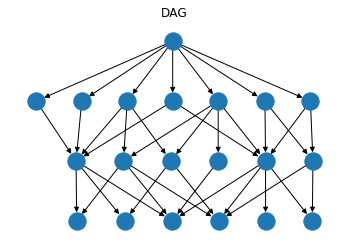

[8,  2600] loss - (total : 0.185885, clf : 0.018708, support : 0.016430, recon : 0.049032, latent : 0.005129), acc - (clf : 1.000000, recon : 0.947917)
[8,  2800] loss - (total : 0.127083, clf : 0.002967, support : 0.013554, recon : 0.021279, latent : 0.002307), acc - (clf : 1.000000, recon : 0.989583)
[ Eval ] loss - (total : 1.898838, clf : 0.331283, support : 0.741250, recon : 0.212913, latent : 0.529408), acc - (clf : 0.910777, support : 0.866608, recon : 0.962603)
comp.sys.mac.hardware : [0, 41, 4]
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 4]
sci.space : [6, 34, 60]
-----
rec.sport.hockey : [7, 18,

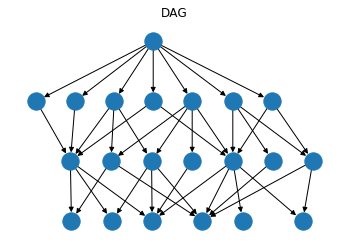

[9,  3000] loss - (total : 0.959619, clf : 0.008670, support : 0.332365, recon : 0.067116, latent : 0.472224), acc - (clf : 1.000000, recon : 0.989583)
[ Eval ] loss - (total : 2.193306, clf : 0.353653, support : 0.841630, recon : 0.220370, latent : 0.704374), acc - (clf : 0.903710, support : 0.854240, recon : 0.965548)
comp.sys.mac.hardware : [0, 41, 4]
talk.politics.mideast : [0, 18, 0]
-----
rec.autos : [2, 48, 60]
rec.motorcycles : [2, 11, 60]
sci.crypt : [2, 48, 0]
sci.electronics : [2, 41, 60]
sci.med : [2, 27, 0]
-----
alt.atheism : [4, 18, 0]
rec.sport.baseball : [4, 11, 95]
talk.politics.guns : [4, 48, 52]
talk.politics.misc : [4, 48, 0]
talk.religion.misc : [4, 18, 52]
-----
soc.religion.christian : [5, 18, 0]
-----
comp.graphics : [6, 41, 68]
comp.windows.x : [6, 41, 4]
sci.space : [6, 34, 60]
-----
rec.sport.hockey : [7, 18, 95]
-----
comp.os.ms-windows.misc : [8, 34, 68]
comp.sys.ibm.pc.hardware : [8, 41, 0]
misc.forsale : [8, 9, 60]


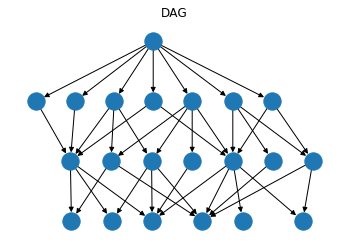

Training complete!


In [5]:
model.fit(data['train']['features'], data['train']['flat_labels']) #, save_dir='train_results/cifar100')